## Adversarial Attacks: Example

### FGSM (Fast Gradient Sign Method):

#### Explanation
Model Training:
A simple CNN is defined and trained on the MNIST dataset. The training loop is kept brief for demonstration.

#### FGSM Attack:
The fgsm_attack function creates an adversarial example by adding noise proportional to the sign of the gradient of the loss with respect to the input image. Even a small epsilon value can sometimes cause the model to misclassify.

#### Evaluation:
The test_adversarial function applies the FGSM attack to each test image (only if it was initially classified correctly) and checks whether the adversarial example fools the model.

#### Visualization:
The code plots a few adversarial examples for different epsilon values, showing the change in prediction.

This example provides a basic starting point to study adversarial attacks in deep learning. You can experiment with different epsilon values or attack methods to further explore the vulnerabilities of neural networks.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Define a simple CNN for MNIST
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # input: 1x28x28, output: 32x28x28
            nn.ReLU(),
            nn.MaxPool2d(2)  # output: 32x14x14
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # 10 classes for MNIST digits
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

# Prepare the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader  = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader   = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

# Initialize model, loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model (only one epoch for demonstration)
model.train()
for epoch in range(1):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

100%|██████████| 9.91M/9.91M [00:00<00:00, 13.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 451kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.07MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.72MB/s]


Epoch [1], Step [100/938], Loss: 0.3963
Epoch [1], Step [200/938], Loss: 0.2901
Epoch [1], Step [300/938], Loss: 0.1396
Epoch [1], Step [400/938], Loss: 0.1234
Epoch [1], Step [500/938], Loss: 0.1901
Epoch [1], Step [600/938], Loss: 0.1156
Epoch [1], Step [700/938], Loss: 0.0840
Epoch [1], Step [800/938], Loss: 0.1001
Epoch [1], Step [900/938], Loss: 0.1077


In [ ]:
# Define FGSM attack function
def fgsm_attack(image, epsilon, data_grad):
    # Get the sign of the gradients
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Clamp the perturbed image to maintain valid pixel range [0, 1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Function to test the model under adversarial attack
def test_adversarial(model, device, test_loader, epsilon):
    model.eval()
    correct = 0
    adv_examples = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        # Forward pass
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]  # original prediction

        # Only attack if the model correctly classifies the image
        if init_pred.item() != target.item():
            continue

        # Calculate loss and backpropagate to get gradient on the input data
        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        # Generate adversarial example using FGSM
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output_adv = model(perturbed_data)
        final_pred = output_adv.max(1, keepdim=True)[1]

        if final_pred.item() == target.item():
            correct += 1
        # Save some examples for visualization (only saving first few)
        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    final_acc = correct / float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc:.4f}")
    return final_acc, adv_examples

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model under adversarial attacks with varying perturbation sizes
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test_adversarial(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9744 / 10000 = 0.9744
Epsilon: 0.05	Test Accuracy = 9125 / 10000 = 0.9125
Epsilon: 0.1	Test Accuracy = 7301 / 10000 = 0.7301
Epsilon: 0.15	Test Accuracy = 4106 / 10000 = 0.4106
Epsilon: 0.2	Test Accuracy = 1416 / 10000 = 0.1416
Epsilon: 0.25	Test Accuracy = 338 / 10000 = 0.0338
Epsilon: 0.3	Test Accuracy = 63 / 10000 = 0.0063


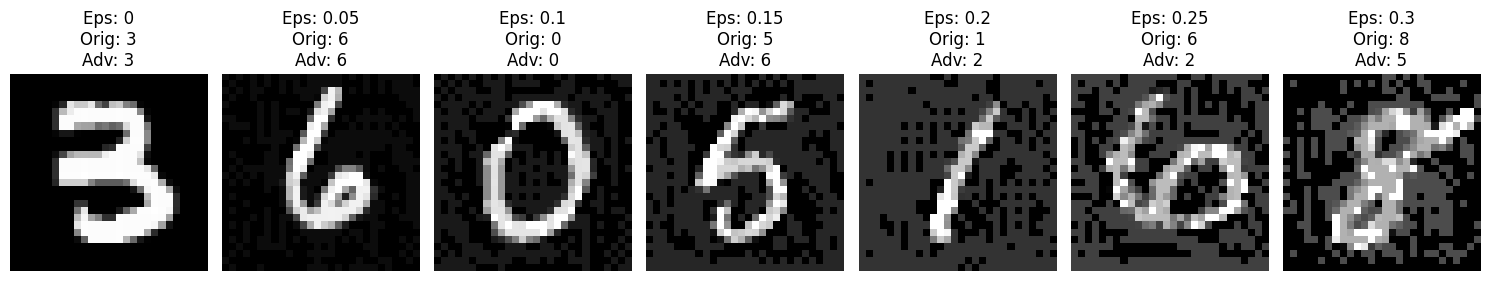

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(epsilons), figsize=(15, 3))
for i, eps in enumerate(epsilons):
    if len(examples[i]) > 0:
        init_pred, final_pred, adv_ex = examples[i][0]
        axes[i].imshow(adv_ex, cmap="gray")
        axes[i].set_title(f"Eps: {eps}\nOrig: {init_pred}\nAdv: {final_pred}")
        axes[i].axis('off')
    else:
        axes[i].set_title(f"Eps: {eps}\nNo adv example")
        axes[i].axis('off')
plt.tight_layout()
plt.show()

---

### PGD (Projected Gradient Descent)

#### Explanation
Model Training:
The CNN model is trained on the MNIST dataset. (Here, we use a single epoch for demonstration purposes.)

#### PGD Attack:
The pgd_attack function starts from a randomly perturbed image (within the allowed epsilon range) and iteratively refines the perturbation. The update step uses the gradient sign multiplied by a small step size (alpha), and after each step, the perturbed image is projected back into the valid range of both the input pixel values and the epsilon-ball around the original image.

#### Evaluation and Visualization:
The test_pgd function applies the attack to test images and calculates the accuracy of the adversarial examples. A few examples are saved and later visualized to see how the perturbations affect the predictions.

This example should give you another perspective on how adversarial attacks work, this time through an iterative method that is generally more robust than the one-step FGSM approach. Enjoy experimenting with it—and feel free to modify parameters like epsilon, alpha, or num_iter to see their effects on the adversarial examples!

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Simple CNN model definition
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 1x28x28 -> 32x28x28
            nn.ReLU(),
            nn.MaxPool2d(2)  # 32x28x28 -> 32x14x14
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # 10 classes for MNIST digits
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

# Data preparation
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader  = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader   = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

# Initialize model, loss and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model (1 epoch for demonstration)
model.train()
for epoch in range(1):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.62MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.03MB/s]


Epoch [1], Step [100/938], Loss: 0.3400
Epoch [1], Step [200/938], Loss: 0.1686
Epoch [1], Step [300/938], Loss: 0.1259
Epoch [1], Step [400/938], Loss: 0.2774
Epoch [1], Step [500/938], Loss: 0.1165
Epoch [1], Step [600/938], Loss: 0.1555
Epoch [1], Step [700/938], Loss: 0.2304
Epoch [1], Step [800/938], Loss: 0.3587
Epoch [1], Step [900/938], Loss: 0.0429


In [ ]:
def pgd_attack(model, images, labels, epsilon, alpha, num_iter):
    # Save the original images for projection
    ori_images = images.clone().detach()
    # Start with a random perturbation within the epsilon-ball
    perturbed_images = images + torch.empty_like(images).uniform_(-epsilon, epsilon)
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    # Detach and enable gradient tracking
    perturbed_images = perturbed_images.detach().clone().requires_grad_()

    for _ in range(num_iter):
        outputs = model(perturbed_images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()
        # Compute gradient sign and update
        grad = perturbed_images.grad.data
        perturbed_images = perturbed_images + alpha * grad.sign()
        # Project back into the epsilon-ball and valid pixel range
        perturbed_images = torch.max(torch.min(perturbed_images, ori_images + epsilon), ori_images - epsilon)
        perturbed_images = torch.clamp(perturbed_images, 0, 1)
        # Detach and re-enable gradient tracking for the next iteration
        perturbed_images = perturbed_images.detach().clone().requires_grad_()

    return perturbed_images

In [ ]:
def test_pgd(model, device, test_loader, epsilon, alpha, num_iter):
    model.eval()
    correct = 0
    pgd_examples = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        # Get initial prediction
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        # Only attack if the initial prediction is correct
        if init_pred.item() != target.item():
            continue

        # Generate adversarial example using PGD
        perturbed_data = pgd_attack(model, data, target, epsilon, alpha, num_iter)
        output_adv = model(perturbed_data)
        final_pred = output_adv.max(1, keepdim=True)[1]

        if final_pred.item() == target.item():
            correct += 1

        if len(pgd_examples) < 5:
            pgd_ex = perturbed_data.squeeze().detach().cpu().numpy()
            pgd_examples.append((init_pred.item(), final_pred.item(), pgd_ex))

    final_acc = correct / float(len(test_loader))
    print(f"Epsilon: {epsilon}, Alpha: {alpha}, Iterations: {num_iter} => Accuracy: {correct}/{len(test_loader)} = {final_acc:.4f}")
    return final_acc, pgd_examples

# Set device and move model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define attack parameters
epsilon = 0.3  # maximum perturbation
alpha = 0.01   # step size per iteration
num_iter = 40  # number of iterations

acc, examples = test_pgd(model, device, test_loader, epsilon, alpha, num_iter)


Epsilon: 0.3, Alpha: 0.01, Iterations: 40 => Accuracy: 0/10000 = 0.0000


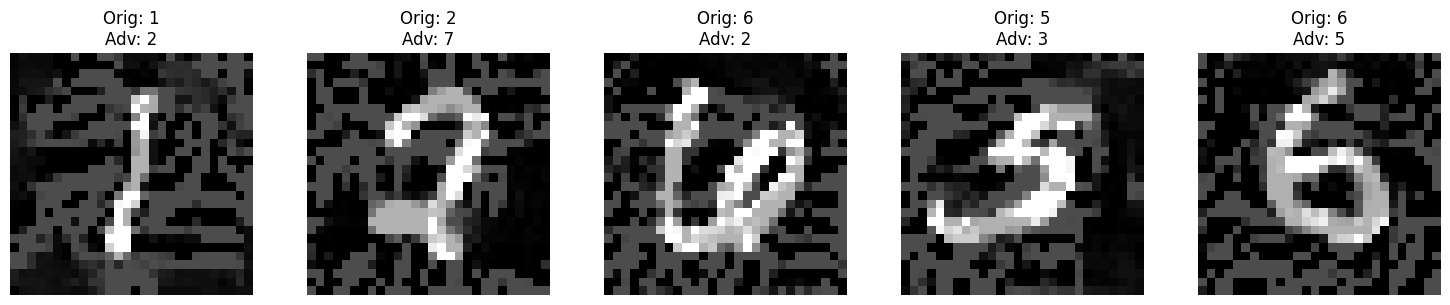

In [ ]:
fig, axes = plt.subplots(1, len(examples), figsize=(15, 3))
for i, (init_pred, final_pred, pgd_ex) in enumerate(examples):
    axes[i].imshow(pgd_ex, cmap="gray")
    axes[i].set_title(f"Orig: {init_pred}\nAdv: {final_pred}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()
